### Environment Setup

#### Import Libraries 

In [1]:
import pandas as pd
import numpy as np
import importlib
import GameAnalytics
import warnings

importlib.reload(GameAnalytics)

from scipy import stats
from scipy.stats import shapiro
from dotenv import load_dotenv
from GameAnalytics import *

In [2]:
warnings.simplefilter("ignore")

In [3]:
load_dotenv() # Load environment variables from .env file

True

#### Connecting to the PostgreSQL Database

In [5]:
client = PostgresClient()           # Create a database client instance
client.connect()                    # Connect to the database

Database configuration loaded successfully
Successfully connected to PostgreSQL


#### Load Data

In [6]:
analytics = GameAnalytics(client)   # Create a game analytics instance
data_postgres = analytics.get_data()         # Fetch data from table into database

### The Data

#### Initial Exploration

In [7]:
data = pd.DataFrame(data_postgres, columns=COLUMNS) # Convert the database to df
print(f"Data's Shape: {data.shape}")

data.head()

Data's Shape: (90189, 5)


,userId,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


The data is from 90,189 players that installed the game while the AB-test was running. The variables are:


* **userid**: This is a unique identifier assigned to each player.
* **version**: Indicates the group to which the player was assigned: the control group sees the gate at level 30 (gate_30), while the test group encounters the gate at level 40 (gate_40).
* **sum_gamerounds**: Represents the total number of rounds a player has played in the first week after installing the game.
* **retention_1**: Shows whether the player returned to play the game one day after the initial installation.
* **retention_7**: Indicates if the player was active and returned to play seven days after they first installed the game.

**Displaying Data Types of Each Column**

In [8]:
for column in data.columns:
    print(f'Column: {column}, Type: {type(data.iloc[0][column])}')

Column: userId, Type: <class 'numpy.int64'>
Column: version, Type: <class 'str'>
Column: sum_gamerounds, Type: <class 'numpy.int64'>
Column: retention_1, Type: <class 'numpy.bool'>
Column: retention_7, Type: <class 'numpy.bool'>


#### Data Cleaning

**Counting Missing Values in Each Column**

In [9]:
pd.isnull(data).sum()

userId            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

**Get Unique values per column**

In [10]:
for column in data.columns:
    if column not in ['userId', 'sum_gamerounds']:
        print(f'Column: {column}, Type: {pd.unique(data[column])}')

Column: version, Type: ['gate_30' 'gate_40']
Column: retention_1, Type: [False  True]
Column: retention_7, Type: [False  True]


**Removing Duplicate Rows Across All Columns**

In [11]:
for column in COLUMNS:
    data.drop_duplicates(keep = 'first', inplace = True)

data.shape

(90189, 5)

As we can see, we removed a duplicate row from the dataframe.

**Rename group values**

In [12]:
data['version'] = data['version'].replace('gate_30', 'control_group')
data['version'] = data['version'].replace('gate_40', 'test_group')

### Exploratory Data Analysis (EDA)

**Visualizing User Counts by A/B Test Group**

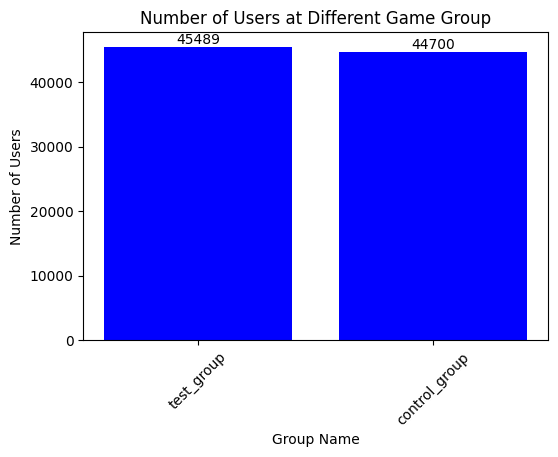

In [13]:
version_df = data['version'].value_counts() # Create a new dataframe that contains only versions names and values

groups = version_df.index.to_list()
users = version_df.values.tolist()

plt.figure(figsize=(6, 4))
bars = plt.bar(groups, users, color='blue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval}', va='bottom', ha='center')

plt.xlabel('Group Name')
plt.ylabel('Number of Users')
plt.title('Number of Users at Different Game Group')
plt.xticks(rotation=45)
plt.show()

#### Sum Game-Rounds

**Detailed Game Round Statistics**

In [14]:
data.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.0,51.872457,195.050858,0.0,0.0,1.0,1.0,3.0,16.0,67.0,134.0,221.0,493.0,49854.0


**Detailed Game Round Statistics by Version - Before Remove Outlier**

In [15]:
data.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
control_group,44700,17.0,52.456264,256.716423,49854
test_group,45489,16.0,51.298776,103.294416,2640


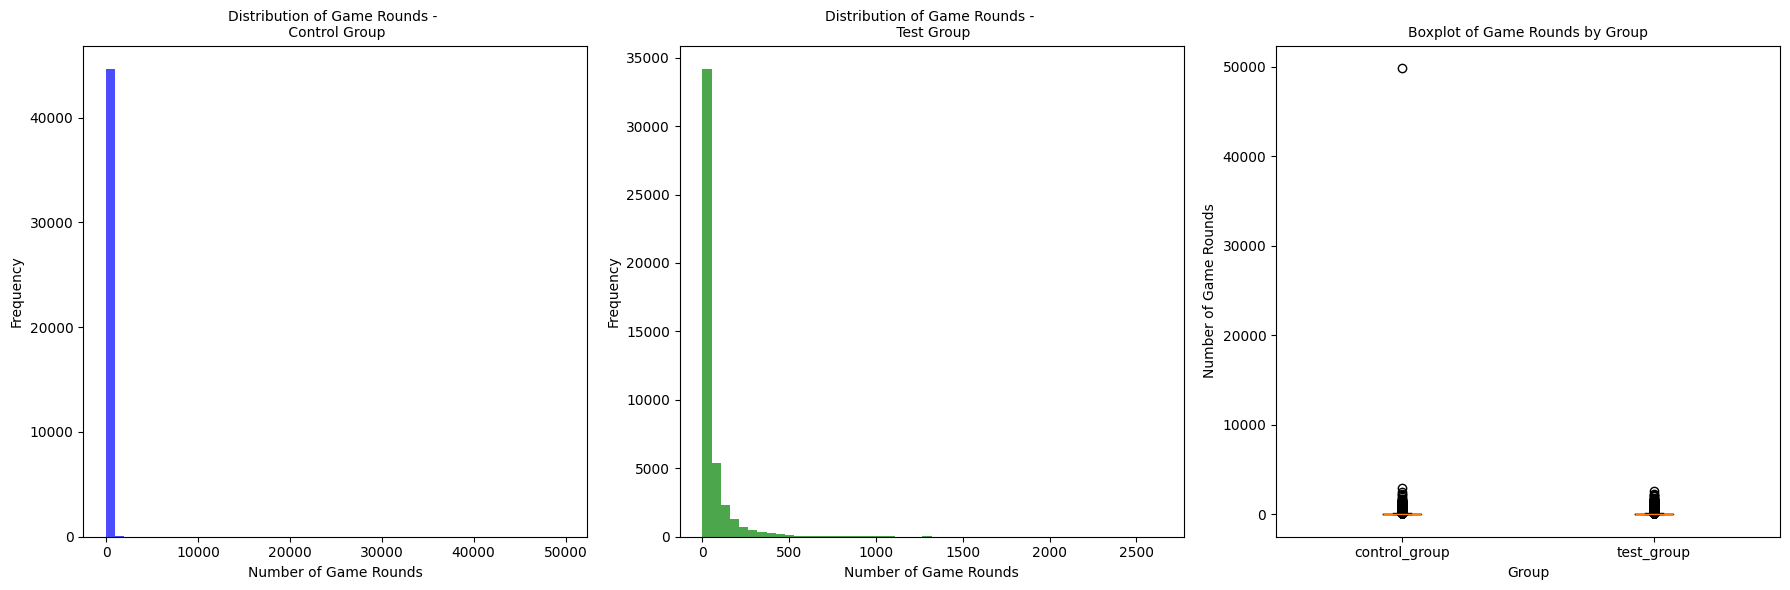

In [16]:
show_distributions_gamerounds(data)

The histograms show that most players in both the control and test groups stop playing at early game stages, with the test group dropping off more sharply.

The boxplot reveals that the control group has an outlier who reached an exceptionally high number (approximately 5k) of game rounds, significantly more than the typical player. 

**Outliers in Each Group**

In [17]:
data[data['version'] == 'control_group']['sum_gamerounds'].value_counts().sort_index(ascending=False)[:3]

sum_gamerounds
49854    1
2961     1
2438     1
Name: count, dtype: int64

In [18]:
data[data['version'] == 'test_group']['sum_gamerounds'].value_counts().sort_index(ascending=False)[:3]

sum_gamerounds
2640    1
2294    1
2124    1
Name: count, dtype: int64

**Remove Outlier**

In [22]:
data = data[data['sum_gamerounds'] < data['sum_gamerounds'].max()]  
print(f"Data's shape: {data.shape}")
data

Data's shape: (90188, 5)


,userId,version,sum_gamerounds,retention_1,retention_7
0,116,control_group,3,False,False
1,337,control_group,38,True,False
2,377,test_group,165,True,False
3,483,test_group,1,False,False
4,488,test_group,179,True,True
...,...,...,...,...,...
90184,9999441,test_group,97,True,False
90185,9999479,test_group,30,False,False
90186,9999710,control_group,28,True,False
90187,9999768,test_group,51,True,False


**Detailed Game Round Statistics by Version - After Remove Outlier**

In [23]:
data.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
control_group,44699,17.0,51.342111,102.057598,2961
test_group,45489,16.0,51.298776,103.294416,2640


The table displays summary statistics for game rounds played by the control group and the test group.
 
The control group, with a slightly higher median of 17 game rounds, seems to engage players marginally better than the test group, which has a median of 16 game rounds. Both groups show similar means around 51 game rounds, but the control group has a slightly higher maximum value of 2961 compared to 2640 in the test group.

**Detailed Game Round Statistics by Version - After Remove Outlier**

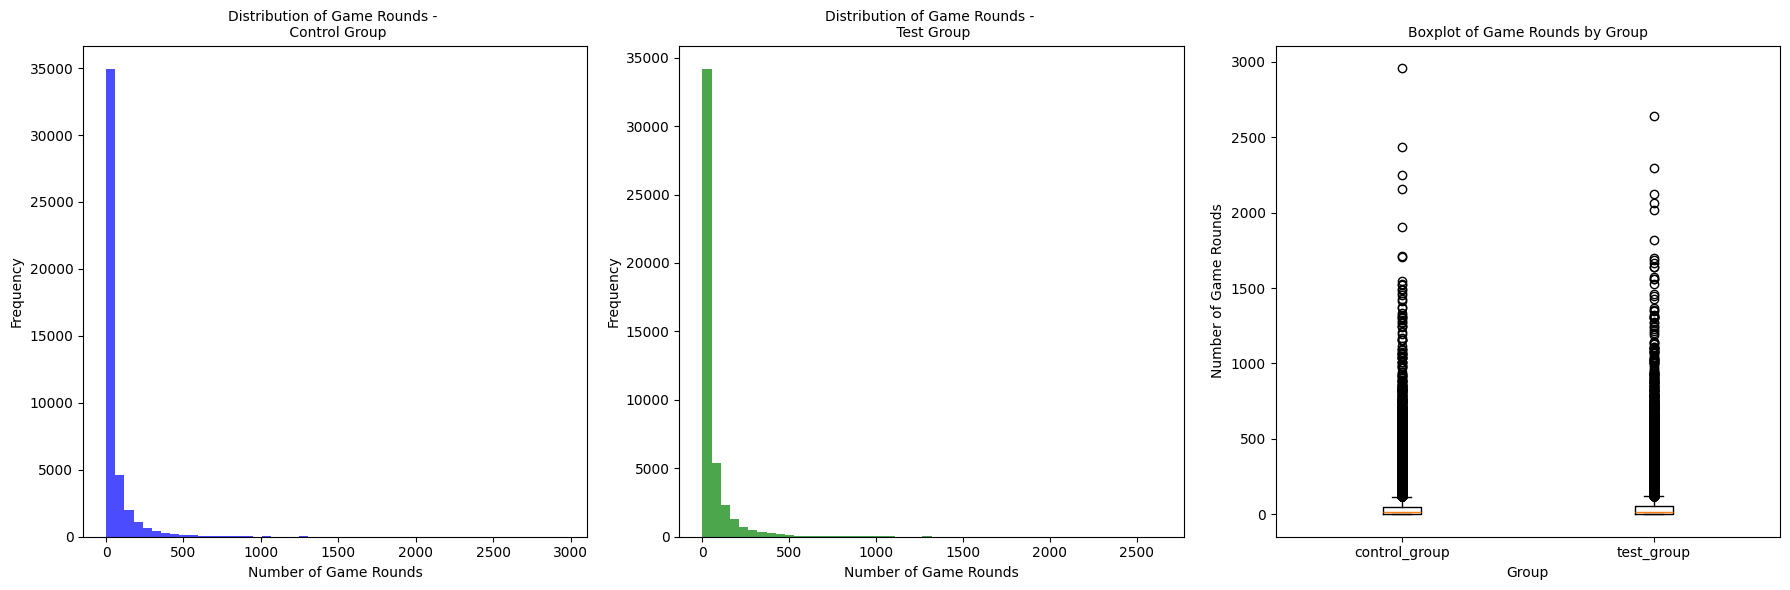

In [24]:
show_distributions_gamerounds(data)

The boxplot after removing the outlier shows that most players in both groups engage in a similar, limited range of game rounds. 

This consistency indicates that few players reach higher levels, suggesting the game could be either too challenging or less engaging as it progresses.

**Number of Users That Never Played**

In [31]:
data[data['sum_gamerounds'] == 0].shape[0]

3994

Out of a total of 90,187 users (after remove a single outlier), 3,994 have never played a single game round. This indicates that approximately 4.4% of users drop off immediately after registration or installation without engaging with the game at all. This significant early drop-off suggests potential issues with the initial user experience, game accessibility, or user expectations not being met, which could be critical areas for improvement to enhance overall user engagement and retention.

**Users Plays In The First 150 Games Rounds**

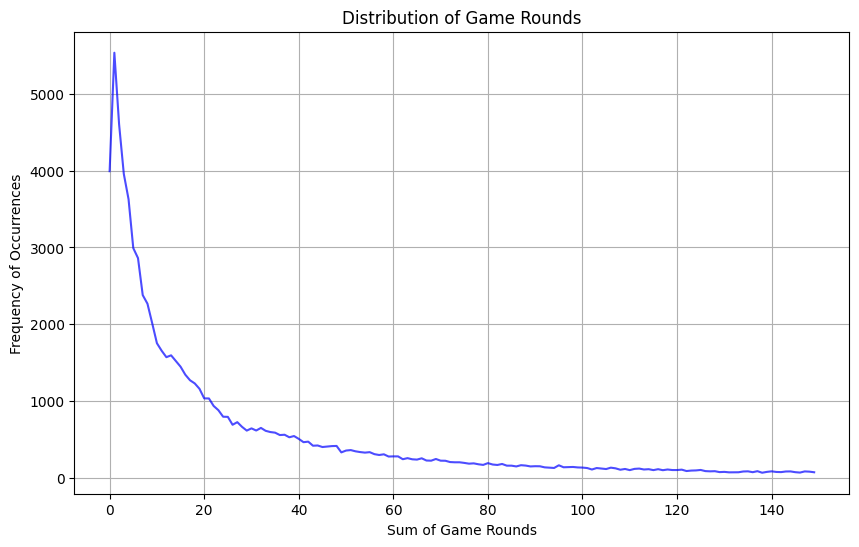

In [32]:
# Organizes the frequency of each sum of game rounds that less 150
users_per_gamerounds = data[['sum_gamerounds']].value_counts().sort_index()  
users_per_gamerounds_df = users_per_gamerounds.reset_index()
users_per_gamerounds_df.columns = ['sum_gamerounds', 'count']
users_per_gamerounds_df = users_per_gamerounds_df[users_per_gamerounds_df['sum_gamerounds'] < 150]

# Creates a line plot to visualize the frequency distribution 
plt.figure(figsize=(10, 6))
plt.plot(users_per_gamerounds_df.index, users_per_gamerounds_df['count'], color='blue', alpha=0.7)
plt.title('Distribution of Game Rounds')
plt.xlabel('Sum of Game Rounds')
plt.ylabel('Frequency of Occurrences')
plt.grid(True)
plt.show()

This distribution shows a sharp decline in frequency after the initial few rounds, with the majority of occurrences concentrated around 0 to 20 rounds.
 
This steep drop-off suggests that many players try the game but quickly lose interest or find it challenging, leading to a rapid decrease in player engagement.
 
The long tail extending towards 140 rounds indicates that while the majority of players stop playing early, a small fraction continues to engage with the game for a longer period. This pattern highlights the importance of optimizing early game experiences to enhance player retention and reduce early drop-offs.

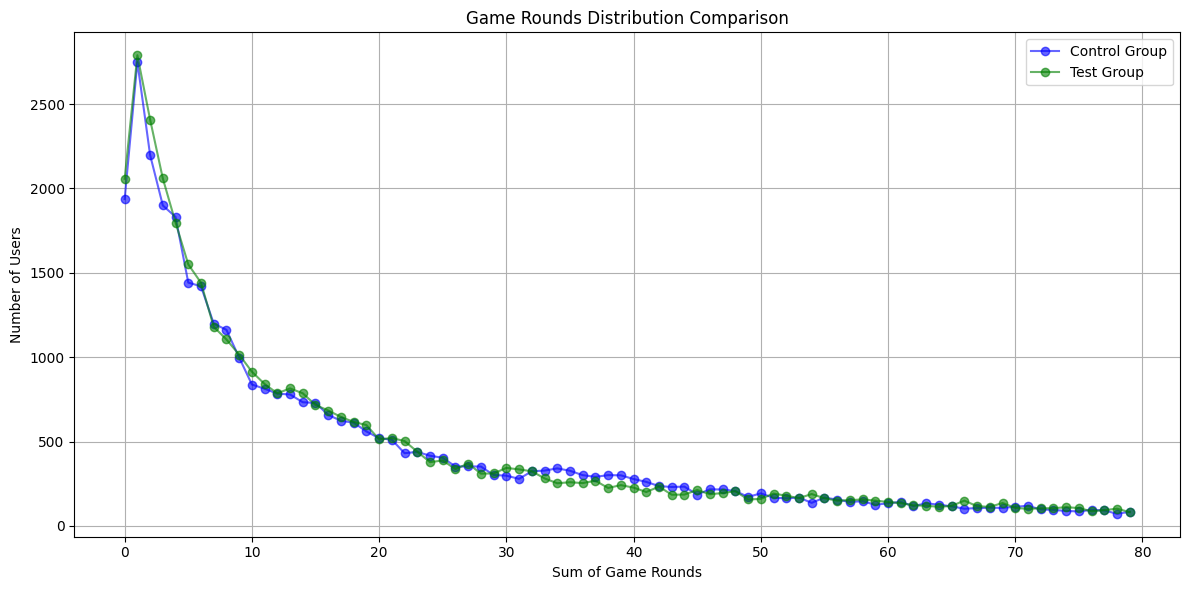

In [23]:
# Group and count the occurrences of each game round sum for each version
group_limit_gamerounds = data[data['sum_gamerounds'] < 80][['sum_gamerounds', 'version']]
control_group_counts = group_limit_gamerounds[group_limit_gamerounds['version'] == 'control_group']['sum_gamerounds'].value_counts().sort_index()
test_group_counts = group_limit_gamerounds[group_limit_gamerounds['version'] == 'test_group']['sum_gamerounds'].value_counts().sort_index()

plt.figure(figsize=(12, 6))

# Plotting both groups on the same graph
plt.plot(control_group_counts.index, control_group_counts.values, label='Control Group', marker='o', linestyle='-', color='blue', alpha = 0.6)
plt.plot(test_group_counts.index, test_group_counts.values, label='Test Group', marker='o', linestyle='-', color='green', alpha = 0.6)

# Setting plot title and labels
plt.title('Game Rounds Distribution Comparison')
plt.xlabel('Sum of Game Rounds')
plt.ylabel('Number of Users')
plt.legend()  # Add a legend to differentiate between groups
plt.grid(True)  # Add grid for better readability

# Show the plot
plt.tight_layout()
plt.show()

The plot shows a sharp decline in player count after the initial rounds for both groups. The control group peaks slightly higher in the early rounds compared to the test group, suggesting that players in the control group might be slightly more engaged initially. However, beyond the initial peak, the distributions of both groups align closely, indicating similar player behavior and retention across later rounds.

**How Many Users Reached per Game-Round?**

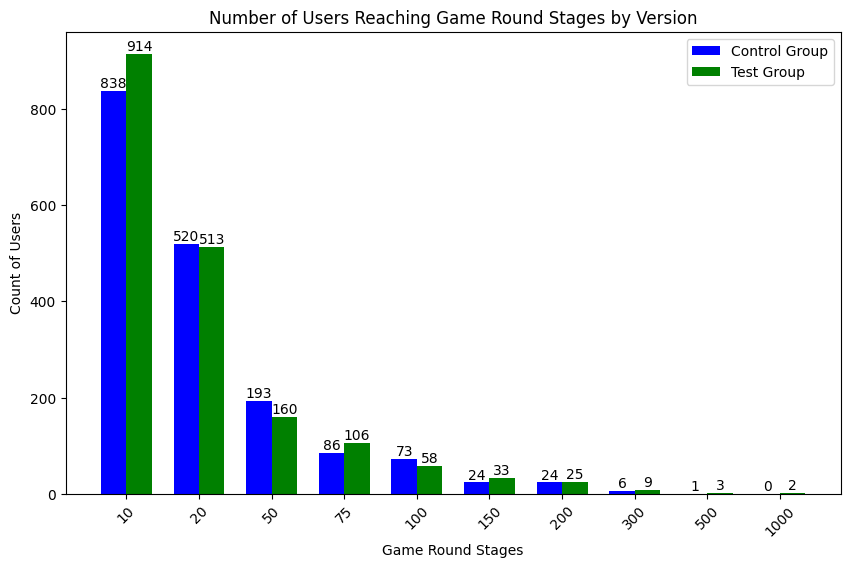

In [33]:
# Define the stages you're interested in
stages = [10, 20, 50, 75, 100, 150, 200, 300, 500, 1000]

# Filter the data to include only the specified game rounds
filtered_data = data[data['sum_gamerounds'].isin(stages)]
grouped_data = filtered_data.groupby(['sum_gamerounds', 'version']).size().unstack(fill_value=0).reset_index()

# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Setting the width for each bar
bar_width = 0.35

# Creating an index for each group of bars
index = np.arange(len(grouped_data))

# Plotting both versions
bars1 = ax.bar(index - bar_width/2, grouped_data['control_group'], bar_width, label='Control Group', color='blue')
bars2 = ax.bar(index + bar_width/2, grouped_data['test_group'], bar_width, label='Test Group', color='green')

for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom')

# Adding labels, title, and custom x-axis tick labels
ax.set_xlabel('Game Round Stages')
ax.set_ylabel('Count of Users')
ax.set_title('Number of Users Reaching Game Round Stages by Version')
ax.set_xticks(index)
ax.set_xticklabels(grouped_data['sum_gamerounds'])
plt.xticks(rotation=45)  

# Adding a legend
ax.legend()
plt.show()

The bar chart shows that more players in the control group reach each game stage compared to the test group, highlighting better engagement or easier gameplay.
 
As game levels increase, the number of players decreases significantly in both groups, indicating a trend of reduced player retention as the game progresses.

#### Retention 1

**All Samples**

In [34]:
pd.DataFrame({"RET1_COUNT": data["retention_1"].value_counts(),
              "RET1_RATIO": data["retention_1"].value_counts() / len(data)})

,RET1_COUNT,RET1_RATIO
retention_1,,
False,50035,0.554786
True,40153,0.445214


A less than half (44.5%) of the players returns one day after installing the game.

**Per Version**

In [35]:
results = []
for version, group in data.groupby('version'):
    total_samples = len(group)
    count_data = group['retention_1'].value_counts()
    ratio_data = group['retention_1'].value_counts(normalize=True)
    results.append({
        'Version': version,
        'True_Count': count_data.get(True, 0),
        'False_Count': count_data.get(False, 0),
        'True_Ratio': ratio_data.get(True, 0),
        'False_Ratio': ratio_data.get(False, 0)
    })

pd.DataFrame(results)

,Version,True_Count,False_Count,True_Ratio,False_Ratio
0,control_group,20034,24665,0.448198,0.551802
1,test_group,20119,25370,0.442283,0.557717


There seems to have been a minor reduction in 1-day retention when the gate was positioned at test_group (44.2%) as opposed to the control group (44.8%).

This change is minimal, yet even slight variations in retention rates can significantly influence outcomes. 

#### Retention 7

**All Samples**

In [36]:
pd.DataFrame({"RET7_COUNT": data["retention_7"].value_counts(),
              "RET7_RATIO": data["retention_7"].value_counts() / len(data)})

,RET7_COUNT,RET7_RATIO
retention_7,,
False,73408,0.813944
True,16780,0.186056


**Results**:

A minority (18.61%) of the players return one day after installing the game.






Per Version

In [37]:
results_7 = []
for version, group in data.groupby('version'):
    total_samples = len(group)
    count_data = group['retention_7'].value_counts()
    ratio_data = group['retention_7'].value_counts(normalize=True)
    results_7.append({
        'Version': version,
        'True_Count': count_data.get(True, 0),
        'False_Count': count_data.get(False, 0),
        'True_Ratio': ratio_data.get(True, 0),
        'False_Ratio': ratio_data.get(False, 0)
    })

pd.DataFrame(results_7)

,Version,True_Count,False_Count,True_Ratio,False_Ratio
0,control_group,8501,36198,0.190183,0.809817
1,test_group,8279,37210,0.182000,0.818000


**Results**:

There seems to have been a minor reduction in 7-day retention when the gate was positioned at the test group (18.2%) as opposed to the control group (19.02%).

This change is minimal, yet even slight variations in retention rates can significantly influence outcomes.

### A/B Test Analysis

 Assumptions:
 
1) Check normality
2) If the distribution is normality - Check homogeneity 

Steps:
1) Split the data to each version (group) by sum_gamerounds (target)
2) Apply Shapiro Test 
3) Check Homogeneity
4) Apply T-Test

#### Split the data to each version (group) by sum_gamerounds (target)

A - Control Group

In [39]:
A_gamerounds = data[data['version'] == "control_group"]['sum_gamerounds']
A_gamerounds.head()

0      3
1     38
6      0
11     0
13    39
Name: sum_gamerounds, dtype: int64

B - Test Group

In [41]:
B_gamerounds = data[data['version'] == "test_group"]['sum_gamerounds']
B_gamerounds.head()

2    165
3      1
4    179
5    187
7      2
Name: sum_gamerounds, dtype: int64

#### Apply Shapiro Test 

In [46]:
p_normal_a = shapiro(A_gamerounds)[1]
print(f'P-value of A (control group): {p_normal_a}')

p_normal_b = shapiro(B_gamerounds)[1]
print(f'P-value of B (test group): {p_normal_b}')

P-value of A (control group): 2.36253070250176e-139
P-value of B (test group): 3.3446548187520663e-140


These values of p-values from a Shapiro-Wilk test, which is incredibly small, indicates strong evidence against the null hypothesis that the data are normally distributed.

In other words, **Both of them are normal distribution**. 

#### Check Homogeneity

In [54]:
leveneTest = stats.levene(A_gamerounds, B_gamerounds)[1]  # Check homogeneity between the groups
print(f'P-value of levene test between the groups: {leveneTest}')

P-value of levene test between the groups: 0.7840494387892463


This value of Levene's test means that there is no significant difference in the variance between the groups.

In other words, **The groups (A and B) are homogeneous**.

#### Apply T-Test

In [53]:
ttest = stats.ttest_ind(A_gamerounds, B_gamerounds, equal_var=True)[1]
print(f'P-value of t-test between the groups: {ttest}')

P-value of t-test between the groups: 0.9494739458256001


#### Summary

In [88]:
# Create summary dataframe
result = pd.DataFrame({
    "AB Hypothesis":[ttest < 0.05, round(ttest, 3)], 
    "Is A Normal Distribution (Shapiro)" : [True if p_normal_a < 0.05 else False, round(p_normal_a, 3)] ,
    "Is B Normal Distribution (Shapiro)"  : [True if p_normal_b < 0.05 else False, round(p_normal_b, 3)] ,
    "Are AB Homogeneous (Levene)" : [True if leveneTest > 0.05 else False, round(leveneTest, 3)]
})
 
# Rename index values
result.rename(index={0: 'Result', 1:'P-value'}, inplace = True)
result

,AB Hypothesis,Is A Normal Distribution (Shapiro),Is B Normal Distribution (Shapiro),Are AB Homogeneous (Levene)
Result,False,True,True,True
P-value,0.949,0.0,0.0,0.784


In [89]:
client.close()

PostgreSQL connection is closed
